#### Final Project: Rick & Morty analysis

# Phase 3: Exploring Data (Laurine)

In [1]:
# imports
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import codecs
import numpy as np

## 1.3. Finding the “favourite words” of the Smith/Sanchez family

**Focus on characters: Rick Sanchez, Morty Smith, Beth Smith, Jerry Smith, Summer Smith**

### REPORT

What the Kaggle study found: https://www.kaggle.com/andradaolteanu/sentiment-analysis-rick-and-morty-scripts (see "most 10 words from the Smith family" plots)

#### 1st approach
- I only used the transcript database of the Kaggle study we found on Sentiment Analysis
- Pre-processing = lower case + exclude characters' name + NLTK tokenization + NLTK lemmatization + remove words with 2 letters or less

**CCL** : 
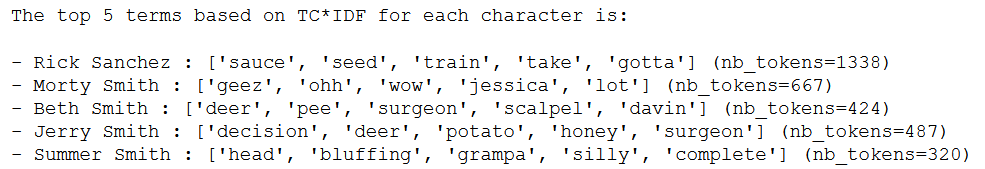

We clearly need more words, especially for Beth, Jerry and Summer! We identify the words from the first episode, when Beth is saving a shot deer.

## Generate data files (tokens)

In [2]:
# load data
df_transcripts = pd.read_csv('transcripts/RickAndMortyScripts.csv')
df_transcripts.head()

,season no.,episode no.,episode name,name,line
0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [3]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)

In [4]:
from os import listdir
from os.path import isfile, join

import nltk
from nltk.tokenize import WordPunctTokenizer

In [5]:
# apply the tokenization process

pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

In [6]:
# get the stopwords list in given language
stopwords = nltk.corpus.stopwords.words('english')
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = nltk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])
    # Save your output for future use
    #f = codecs.open('character_words_tokens/'+aFile, "w+", "utf-8")
    #f.write(character_page)
    #f.close()

## Overview of the whole family words

In [7]:
from nltk.corpus import PlaintextCorpusReader

In [8]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = nltk.Text(familyCorpus.words())

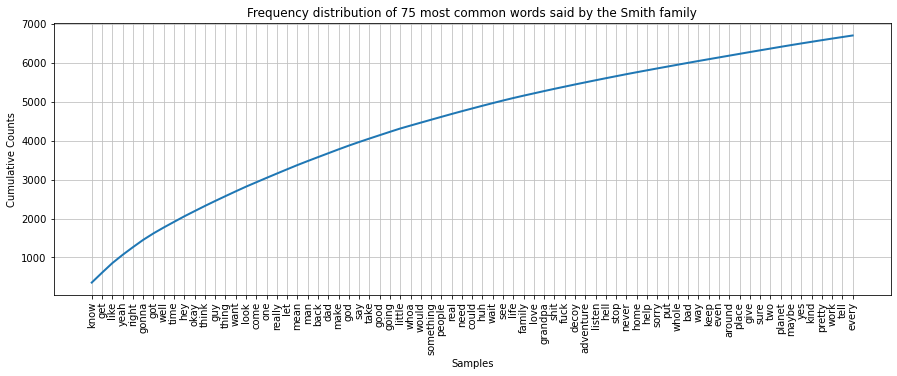

In [9]:
# get the freq distribution of tokens
fdist_family = nltk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

## The favourites words of each character from the Smith family >> TC-IDF

Why TC? Better to plot wordclouds later.

In [10]:
# get one document (of tokens) per character
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [11]:
# compute the TC of each character
char_fdist = {aCharacter:nltk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

The top 5 terms for each character is:

- Rick Sanchez : ['get', 'know', 'gonna', 'right', 'like']
- Morty Smith : ['know', 'like', 'get', 'right', 'yeah']
- Beth Smith : ['dad', 'know', 'okay', 'like', 'want']
- Jerry Smith : ['well', 'know', 'like', 'hey', 'guy']
- Summer Smith : ['grandpa', 'god', 'yeah', 'like', 'dad']


In [12]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [13]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

The top 5 terms based on TC*IDF for each character is:

- Rick Sanchez : ['sauce', 'number', 'bunch', 'season', 'piece'] (nb_tokens=2952)
- Morty Smith : ['ohh', 'duane', 'geez', 'ohhhh', 'bawk'] (nb_tokens=1449)
- Beth Smith : ['surgeon', 'cling', 'performing', 'surgery', 'davin'] (nb_tokens=746)
- Jerry Smith : ['apple', 'pluto', 'tru', 'award', 'potato'] (nb_tokens=1139)
- Summer Smith : ['drum', 'needful', 'bluffing', 'nancy', 'ethan'] (nb_tokens=792)


# Word clouds

In [14]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [15]:
def plot_wordcloud(chosen_element, documents_dic, TC_IDF_dic, aMaskFileName, aFigure):
    """ 
    Generate N wordclouds (based on given chosen_elements) using 
    - documents_dic {aKey:aDocument},
    - TC_IDF_dic {aKey{aWord:aScore}},
    in the matplotlib.pyplot Figure (aFigure) with a fancy mask (aMaskFileName) if wanted
    """
    if aMaskFileName != None:
        mask = np.array(Image.open(aMaskFileName))
    
    # Adjust the number of occurrences of each word based on TC-IDF
    list_to_wordcloud = []
    for aTerm in list(documents_dic[chosen_element]):
        multiplicator = round(TC_IDF_dic[chosen_element][aTerm])
        list_to_wordcloud = list_to_wordcloud + multiplicator*[aTerm]
        
    # Generate a word cloud image
    if aMaskFileName != None:
        wordcloud = WordCloud(background_color="white", mask=mask, collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        # create coloring from image
        image_colors = ImageColorGenerator(mask)
        aFigure.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        wordcloud = WordCloud(background_color="white", collocations = False).generate(''.join([w+' ' for w in list_to_wordcloud]))
        aFigure.imshow(wordcloud, interpolation='bilinear')   
    aFigure.set_title(chosen_element, size=15)
    aFigure.axis("off")

In [16]:
# get masks for plots
url_base_masks = "masks/"
all_masks = ["rick_blue.png", "morty_yellow.png", "beth_red.png", "jerry_green.png", 'summer_pink.png']
all_masks = [ url_base_masks+aMaskFileName for aMaskFileName in all_masks ]

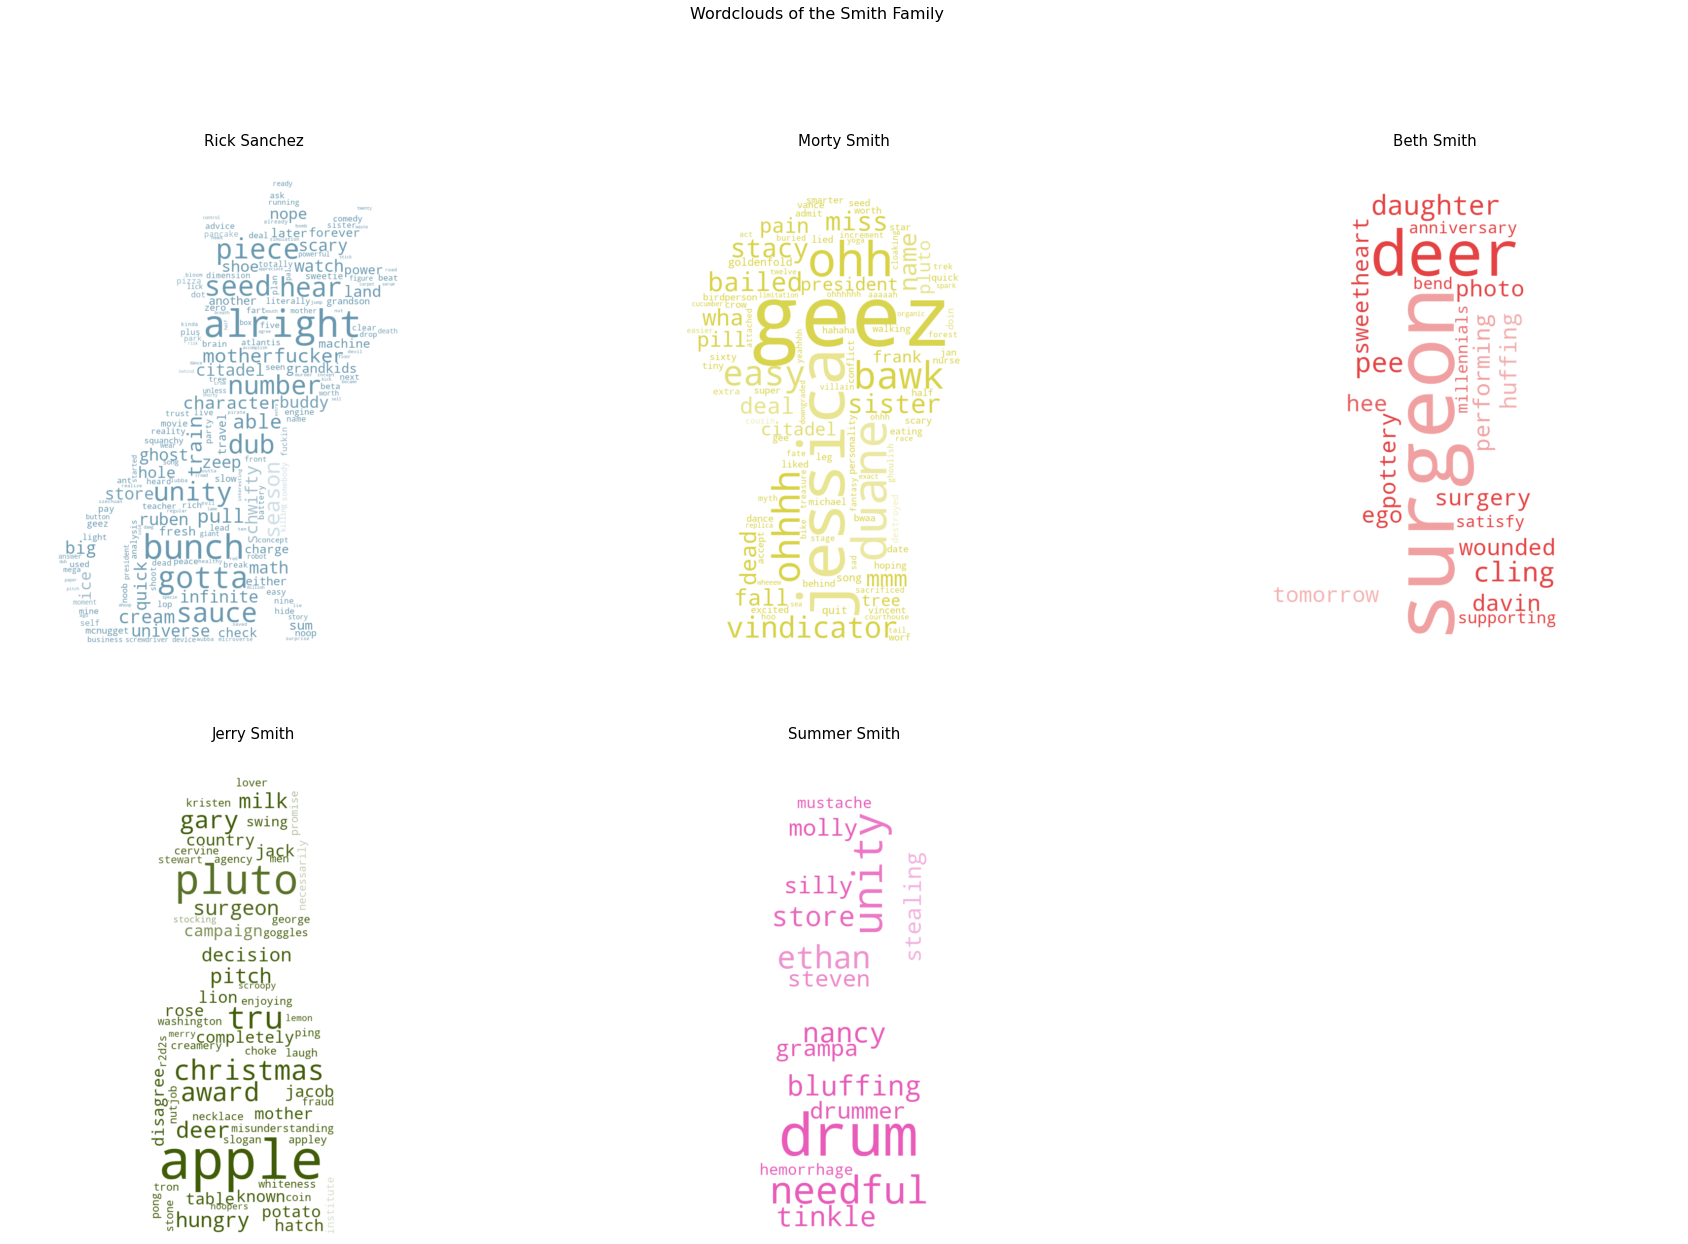

In [20]:
# plot wordclouds
fig, axes = plt.subplots(2,3,figsize=(30,20), subplot_kw={'xticks':[], 'yticks':[]})
fig.suptitle("Wordclouds of the Smith Family", fontsize=16)

for i,ax in enumerate(axes.flat):
    if i<5:
        plot_wordcloud(list(family_list.values())[i], char_documents, family_TC_IDF, all_masks[i], ax)
    else:
        ax.set_visible(False)
plt.show()

# Get bigrams

In [18]:
def get_50_most_frequent_bigrams_not_stopwords(aText, language = 'english', top_nb = 50):
    """Get  the 50 most most frequent bigrams of a text that are not stopwords. 
    By default, the text is in English"""
    # get the stopwords list in given language
    stopwords = nltk.corpus.stopwords.words(language)
    # drop stopwords from text and punctuation
    content = nltk.Text([w for w in aText if w.lower() not in stopwords and w.isalnum()])
    # get bigrams
    bigrams_list = list(nltk.bigrams(content))
    # compute frequency distribution for bigrams
    fdist_bigrams = nltk.FreqDist([a+' '+b for (a,b) in bigrams_list])
    # return 50 most common bigrams
    return fdist_bigrams.most_common(top_nb)

In [19]:
for aCharacter in family_list.values():
    print("For "+aCharacter+' : ')
    print(get_50_most_frequent_bigrams_not_stopwords(char_documents[aCharacter], top_nb=5))

For Rick Sanchez : 
[('look like', 19), ('whoa whoa', 15), ('portal gun', 10), ('yeah yeah', 10), ('let get', 9)]
For Morty Smith : 
[('know mean', 8), ('hey know', 7), ('yeah know', 7), ('gonna get', 6), ('let get', 5)]
For Beth Smith : 
[('holy crap', 3), ('open door', 3), ('decoy family', 3), ('back life', 2), ('way dad', 2)]
For Jerry Smith : 
[('pluto planet', 7), ('planet planet', 6), ('whoa whoa', 5), ('sleepy gary', 5), ('look like', 4)]
For Summer Smith : 
[('god god', 6), ('ooh ooh', 6), ('drum drum', 5), ('yes yes', 3), ('going come', 3)]


# Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?

Use of NRC lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [20]:
df_NRC = pd.read_csv('lexicons/NRC_sentiment_lexicon.csv')
df_NRC_VAD = pd.read_csv('lexicons/NRC-VAD-Lexicon.csv')

In [31]:
def combine_lines(aDataFrame):
    result = ''
    for _, aRow in aDataFrame.iterrows():
        result += aRow.line+' '
    return result

def get_word_tokens(aTextOfLines):
    """ Lower + tokenization + remove punctuation """
    # Set to lower case
    aTextOfLines = aTextOfLines.lower()
    # Tokenize
    tokens = tk.tokenize(aTextOfLines)
    # Remove punctuation
    tokens = [aToken for aToken in tokens if aToken.isalnum()]
    # Lemmatize 
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def analyse_text_NRC(aText, aDF = None):
    """ Get the NRC sentments + VAD scores of a given text (aText)
    Output : dict of VAD scores / dict of sentiments scores / tokens / text """
    tokens = get_word_tokens(aText)
    
    result_sentiments_df = df_NRC[df_NRC.Word.isin(tokens)]
    result_VAD_df = df_NRC_VAD[df_NRC_VAD.Word.isin(tokens)]
    
    result_sentiments_dict = result_sentiments_df.sum().drop('Word')/len(result_sentiments_df)
    result_VAD_dict = result_VAD_df.sum().drop('Word')/len(result_VAD_df)
    result_sentiments_dict = dict(sorted(result_sentiments_dict.items(), reverse=True, key=lambda x:x[1]))
    result_VAD_dict = dict(sorted(result_VAD_dict.items(), reverse=True, key=lambda x:x[1]))
    
    return {'VAD scores':result_VAD_dict, 'sentiment scores':result_sentiments_dict, 'tokens':tokens, 'lines':aText, 'df':aDF}

def get_df_substract(source_char, target_char):
    return df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(target_char))]

def analyse_interactions_NRC(source_char, target_char):
    """ Get the NRC sentiments + VAD scores when source_char talk to target_char """
    df = get_df_substract(source_char, target_char)
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

def analyse_one_char_words(source_char):
    """ Get the NRC sentiments + VAD scores for only source_char lines """
    df = df_transcripts[df_transcripts.name==source_char]
    text = combine_lines(df)
    return analyse_text_NRC(text, df)

Detail of VAD sentiments:
- valence: from NEGATIVE/DISPLEASURE to POSITIVE/PLEASURE
- arousal: from CALM/PASSIVE to EXCITED/ACTIVE
- dominance: FROM WEAK/CONTROLLED to POWERFUL/CONTROL

Detail of NRC sentiments: anger, fear, anticipation, trust, surprise, sadness, joy, or disgust

In [ ]:
df_family_interactions = pd.read_csv('')

In [45]:
df_family_interactions.sort_values('Dominance',ascending=False)

,Source,Target,Nb_tokens,Arousal,Dominance,Valence,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,Rick,Morty,10607,-1.0000,1.0000,1.0000,-0.9998,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
4,Morty,Rick,4298,-1.0000,0.9998,1.0000,-0.9999,-0.9998,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
6,Morty,Summer,619,-0.9996,0.9961,0.9998,-0.9982,0.9779,-0.9995,-0.9996,-0.9993,-0.9969,-0.9997,-0.9982,-0.9998,-0.9993
2,Rick,Jerry,1303,-0.9999,0.9957,0.9999,-0.9988,-0.9995,-0.9999,-0.9999,-0.9999,-0.9999,-0.9999,-0.9999,-0.9999,-0.9998
13,Jerry,Beth,473,-0.9852,0.9957,0.9995,-0.9681,-0.9964,-0.9991,-0.9994,-0.9994,-0.9994,-0.9971,-0.9994,-0.9997,-0.9898
3,Rick,Summer,627,-0.9995,0.9946,0.9999,-0.9964,-0.9921,-0.9997,-0.9997,-0.9998,-0.9998,-0.9997,-0.9998,-0.9997,-0.9984
8,Beth,Morty,276,-0.9982,0.9942,0.9995,-0.5876,-0.9869,-0.9991,-0.9922,-0.9990,-0.9991,-0.9795,-0.9981,-0.9988,-0.9922
10,Beth,Summer,175,-0.9768,0.9890,0.9963,-0.9288,-0.9769,-0.9942,-0.9769,-0.9942,-0.9970,-0.9769,-0.9935,-0.9904,0.0000
12,Jerry,Morty,347,-0.9989,0.9836,0.9996,-0.8275,-0.9288,-0.9980,-0.9978,-0.9990,-0.9989,-0.9916,-0.9985,-0.9990,-0.9935
16,Summer,Morty,259,0.7506,0.9760,0.9391,-0.9952,0.9874,-0.9921,-0.9984,-0.9658,-0.9901,-0.9991,-0.9967,-0.9988,-0.9984


In [24]:
# Other metrics
interactions_other_scores = []

for aSourceChar in family_list.keys():
    for aTargetChar in family_list.keys():
        results_perso = analyse_one_char_words(aSourceChar)
        nb_tokens_total = len(results_perso['tokens'])
        if aSourceChar != aTargetChar:
            results = analyse_interactions_NRC(aSourceChar,aTargetChar)
            nb_tokens = len(results['tokens'])
            if nb_tokens > 100 :
                nb_interrogations = results['lines'].count('?')
                nb_exclamations = results['lines'].count('!')
                nb_egocentric = results['lines'].lower().count('i')+results['lines'].lower().count('me')+results['lines'].lower().count('my')
                nb_you = results['lines'].lower().count('you')
                aRow = [aSourceChar, aTargetChar, nb_tokens, nb_tokens/nb_tokens_total, nb_interrogations/nb_tokens, nb_exclamations/nb_tokens, nb_egocentric/nb_tokens, nb_you/nb_tokens]
                interactions_other_scores.append(aRow)

# to dataframe
df_interactions_other_scores = pd.DataFrame(interactions_other_scores,columns=['Source','Target','Nb_tokens','Ratio', 'Interrogation','Exclamation','Egocentric','You'])

In [28]:
df_interactions_other_scores.sort_values('Interrogation',ascending=False)

,Source,Target,Nb_tokens,Ratio,Interrogation,Exclamation,Egocentric,You
4,Morty,Rick,4298,0.382520,0.033737,0.039321,0.333876,0.047697
6,Beth,Morty,276,0.073836,0.032609,0.003623,0.304348,0.050725
12,Summer,Rick,440,0.118758,0.031818,0.034091,0.304545,0.047727
9,Jerry,Rick,473,0.079031,0.029598,0.016913,0.321353,0.061311
2,Rick,Jerry,1303,0.054382,0.024559,0.013047,0.297774,0.055257
7,Beth,Jerry,674,0.180310,0.020772,0.014837,0.286350,0.051929
1,Rick,Beth,670,0.027963,0.017910,0.005970,0.255224,0.040299
8,Beth,Summer,175,0.046816,0.017143,0.022857,0.314286,0.051429
11,Jerry,Beth,473,0.079031,0.016913,0.023256,0.334038,0.042283
0,Rick,Morty,10607,0.442696,0.015273,0.019798,0.281512,0.044405


In [33]:
combine_lines(get_df_substract('Rick','Jerry'))

'Listen, Jerry. I-I-I don\'t want to overstep my bounds or anything. It\'s your house. It\'s your world. You\'re a real Julius Caesar but I\'ll tell you something—tell you how I feel about school, Jerry. It\'s a waste of time.  Buncha people running around, bumping into each other. G-guy up front says, "two plus two." The people in the back say, "four." Then the—then the bell rings, and they give you a carton of milk and a piece of paper that says you can go take a dump or something. I mean, it\'s not a place for smart people, Jerry. And I know that\'s not a popular opinion, but it\'s my two cents on the issue.  This was a good breakfast, Beth. You really made the crap out of those eggs. I wish your mother was here to eat them. Oh, hi, Jerry. Oh, my goodness, Morty! What are you doing out of class? We talked about this. Your-your parents and I are very disappointed in-in this behavior... No? No takers? Okay, Jerry. You drive a hard bargain, but what am I supposed to do? Say no? You-you

# Topic detection

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


# create a list of lists with clean description of each character
family_tokens_dict = {}

for aName, aFullName in family_list.items():
    character_page = open(corpus_root+'/'+aFullName+'.txt', encoding="utf-8").read() 
    family_tokens_dict[aName] = character_page.split(' ')
    
# build the dictionary id2word by using corpora.Dictionary(YOUR_LIST_OF_LISTS)
id2word = corpora.Dictionary(list(family_tokens_dict.values()))

# build your corpus by mapping the words in YOUR_LIST_OF_LISTS as follows id2word.doc2bow(PAGE)
# Bag-of-words representation of the documents.
corpus = [id2word.doc2bow(doc) for doc in list(family_tokens_dict.values())]

# run the LDA model with input id2word and your corpus
LDA_model_test = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, alpha=0.3)

# build many LDA models with different values of number of topics 𝑁𝑡
number_of_topics_values = [1,2,5,10,20,40]
coherence_score_dict = {}

for aNumberOfTopics in number_of_topics_values:
    aLDAmodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=aNumberOfTopics)
    top_topics = aLDAmodel.top_topics(corpus)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / aNumberOfTopics
    coherence_score_dict[aNumberOfTopics]=avg_topic_coherence
    # print("For {} topics, we obtain a coherence score of {}".format(aNumberOfTopics, avg_topic_coherence))

# plot the coherence score
plt.plot(coherence_score_dict.keys(), coherence_score_dict.values(), marker='o', linestyle='--')
plt.title("Coherence score based on the number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Avg topic coherence")
plt.show()

# get best model

# Pick the 𝑁𝑡 that gives the highest coherence value. 
coherence_score_dict = dict(sorted(coherence_score_dict.items(), reverse=True, key=lambda x: x[1]))
best_Nt = list(coherence_score_dict.keys())[0]
best_coherence_score = coherence_score_dict[best_Nt]
print("The best number of topics is {} which results a coherence score of {}".format(best_Nt, best_coherence_score))
best_LDAmodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=best_Nt)

best_LDAmodel.show_topics()

---

# Study Beth and Jerry marriage through seasons

In [ ]:
def add_line_to_season(aRow):
    seasons_strings[aRow['season no.']] += aRow['line']

seasons_strings = {k:'' for k in range (1,6)}

for aSeason in range(1,6):
    df_season = df_transcripts[df_transcripts['season no.']==aSeason]
    _ = df_season.apply(add_line_to_season, axis=1)
    # Save your output for future use
    # f = codecs.open('transcripts/per_season/S0'+str(aSeason)+'.txt', "w+", "utf-8")
    # f.write(seasons_strings[aSeason])
    # f.close()

In [ ]:
# create NLTK objects: Corpus and Text
corpus_root = 'transcripts/per_season'
all_files = [f for f in listdir(corpus_root) if isfile(join(corpus_root, f))]
seasonCorpus = PlaintextCorpusReader(corpus_root, all_files)
seasonText = nltk.Text(seasonCorpus.words())

In [ ]:
seasonText.dispersion_plot(["parents","divorce"])

In [ ]:
seasonText.concordance('divorce')

In [ ]:
seasonText.similar("family")

In [ ]:
# get one document per season
season_documents = {aSeason:nltk.Text(seasonCorpus.words(['S0'+str(aSeason)+'.txt'])) for aSeason in seasons_strings.keys()}
season_documents

In [ ]:
# functions from Natural Language Processing with Python (NLPP), Chapter 1.4
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [ ]:
lexical_diversity(char_documents['Rick Sanchez'])

In [ ]:
cfd_seasons = nltk.ConditionalFreqDist(
    (target, aSeason) 
    for aSeason in range(1,6)
    for w in seasonCorpus.words(['S0'+str(aSeason)+'.txt'])
    for target in ['rick']
    if w.lower().startswith(target)
)

plt.figure(figsize=(18,7))
plt.title("Conditional Frequency Distribution of 'divorce' words in the transcripts over seasons")
_ = cfd_seasons.plot()